In [1]:
import pandas as pd
from math import sin, cos, sqrt, atan2, radians
import numpy as np
import os
import time
import gc
import geopandas as gpd
from geolib import geohash
import matplotlib.pyplot as plt
# geohash.encode(latitude, longitude, precision)
# >>> geohash.encode('70.2995', '-27.9993', 7)
# >>> gkkpfve
# >>> geohash.decode('gkkpfve')
# >>> (70.2995, -27.9993)
# >>> neighbours = geohash.neighbours('gcpuyph')
# >>> neighbours
%matplotlib inline

In [2]:
from shapely.geometry import Point, Polygon

In [3]:
city_df = gpd.read_file("king_county_admin_mapfiles/city.shp")

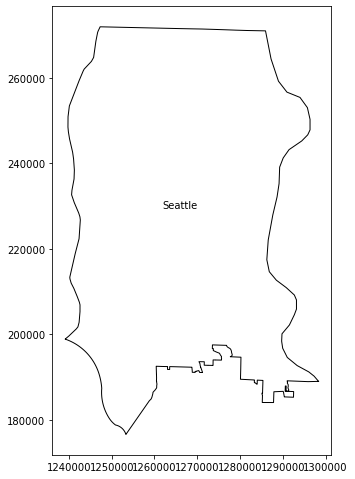

In [4]:
fig, ax = plt.subplots(figsize=(5,12))
city_of_interest = 'Seattle'
single_city = city_df[city_df['CITYNAME']==city_of_interest].copy()

single_city.plot(color='none', 
                   edgecolor='black', 
                   legend=True,
                  ax=ax)

_ = single_city.apply(lambda x: ax.annotate(s=x['CITYNAME'], 
                                           xy=(x.geometry.centroid.x, 
                                               x.geometry.centroid.y), ha='center'),axis=1)

In [5]:
single_city.to_crs({'init': 'epsg:4326'}, inplace=True)

In [6]:
seattle_bounds = single_city.bounds.values[0].tolist()
seattle_bounds

[-122.45968008362588,
 47.47334752062687,
 -122.21723116846032,
 47.73424598428268]

In [7]:
upperleft_lon = single_city.bounds.minx.values[0]
upperleft_lat = single_city.bounds.maxy.values[0]

In [8]:
upperleft_geohash = geohash.encode(upperleft_lat, upperleft_lon, precision=9)

## test the function to draw the bounding box

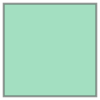

In [9]:
hash_bounds = geohash.bounds(upperleft_geohash)
n_y = hash_bounds.ne.lat
w_x = hash_bounds.sw.lon
s_y = hash_bounds.sw.lat
e_x = hash_bounds.ne.lon
nw_pt = [w_x, n_y]
sw_pt = [w_x, s_y]
ne_pt = [e_x, n_y]
se_pt = [e_x, s_y]
Polygon([nw_pt, sw_pt, se_pt, ne_pt, nw_pt])

In [10]:
#modified from source: https://blog.tafkas.net/2018/09/28/creating-a-grid-based-on-geohashes/
def is_geohash_in_bounding_box(current_geohash, bbox_coordinates):
    """Checks if the box of a geohash is inside the bounding box

    :param current_geohash: a geohash
    :param bbox_coordinates: bounding box coordinates
    :return: true if the the center of the geohash is in the bounding box
    """

    coordinates = geohash.decode(current_geohash)
    geohash_in_bounding_box = (bbox_coordinates[1] < coordinates[0] < bbox_coordinates[3]) and (
            bbox_coordinates[0] < coordinates[1] < bbox_coordinates[2])
    return geohash_in_bounding_box

def build_geohash_box(current_geohash):
    """Returns a shapely Polygon for a given geohash

    :param current_geohash: a geohash
    :return: a list representation of th polygon
    """
    hash_bounds = geohash.bounds(current_geohash)
    n_y = hash_bounds.ne.lat
    w_x = hash_bounds.sw.lon
    s_y = hash_bounds.sw.lat
    e_x = hash_bounds.ne.lon
    nw_pt = [w_x, n_y]
    sw_pt = [w_x, s_y]
    ne_pt = [e_x, n_y]
    se_pt = [e_x, s_y]
    return Polygon([nw_pt, sw_pt, se_pt, ne_pt, nw_pt])

def compute_geohash_tiles(bbox_coordinates, geohash_precision):
    """Computes all geohash tile in the given bounding box

    :param bbox_coordinates: the bounding box coordinates of the geohashes
    :return: a list of geohashes
    Geohash length	Cell width	Cell height
    1	≤ 5,000km	×	5,000km
    2	≤ 1,250km	×	625km
    3	≤ 156km	×	156km
    4	≤ 39.1km	×	19.5km
    5	≤ 4.89km	×	4.89km
    6	≤ 1.22km	×	0.61km
    7	≤ 153m	×	153m
    8	≤ 38.2m	×	19.1m
    9	≤ 4.77m	×	4.77m
    10	≤ 1.19m	×	0.596m
    11	≤ 149mm	×	149mm
    12	≤ 37.2mm	×	18.6mm
    """

    checked_geohashes = set()
    geohash_stack = set()
    geohashes = []
    #geohash_precision = 7
    # get center of bounding box, assuming the earth is flat ;)
    center_latitude = (bbox_coordinates[1] + bbox_coordinates[3]) / 2
    center_longitude = (bbox_coordinates[0] + bbox_coordinates[2]) / 2

    center_geohash = geohash.encode(center_latitude, center_longitude, precision=geohash_precision)
    geohashes.append(center_geohash)
    geohash_stack.add(center_geohash)
    checked_geohashes.add(center_geohash)
    while len(geohash_stack) > 0:
        current_geohash = geohash_stack.pop()
        neighbors = geohash.neighbours(current_geohash)
        for neighbor in neighbors:
            if neighbor not in checked_geohashes and is_geohash_in_bounding_box(neighbor, bbox_coordinates):
                geohashes.append(neighbor)
                geohash_stack.add(neighbor)
                checked_geohashes.add(neighbor)
    return geohashes

In [11]:
geohash_precision = 6
geohash_list = compute_geohash_tiles(seattle_bounds, geohash_precision)

In [12]:
seattle_geohash_df = pd.DataFrame(geohash_list, columns=['geohash'])

In [13]:
seattle_geohash_df['geometry'] = seattle_geohash_df.apply(lambda x: build_geohash_box(x['geohash']), axis=1)

In [14]:
seattle_geohash_gpd = gpd.GeoDataFrame(seattle_geohash_df[['geohash']], crs={'init':'4326'}, geometry=seattle_geohash_df['geometry'].tolist())

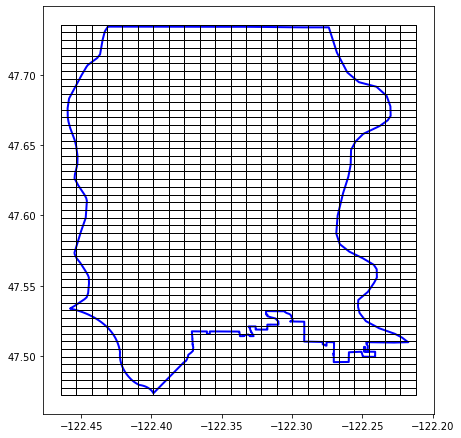

In [15]:
fig, ax = plt.subplots(figsize=(7,20))
single_city.plot(ax=ax, color='None',edgecolor='blue',linewidth=2 )
seattle_geohash_gpd.plot(ax=ax, color='None',edgecolor='black')


# save to json if you want to view on a web map or QGIS etc

In [16]:
seattle_geohash_json = seattle_geohash_gpd.to_json()

In [17]:
with open(f"seattle_geohash_boxes_level{geohash_precision}.geojson", 'w') as f:
    f.write(seattle_geohash_json)